### Import libraries

In [1]:
import sys
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from carPrice import * 
from util import set_gpu_limit, make_tensor_dataset,make_model, plot_metrics,coeff_estimation
%load_ext autoreload
%autoreload 2

In [4]:
set_gpu_limit(6)

### Import data for regular NN without categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_onehot_data.csv")

### Garbage collect

In [6]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Set up base parameter for a base regression model

In [7]:
BATCH_SIZE = 256 
input_size = data.drop("price",axis=1).shape[1]
MAX_EPOCH = 1000
lr = 1e-3
l2 = 0 
SIZES = [512,512]
METRICS = ["MAPE","MAE"]

### Set up a base regression model

In [8]:
base_model = make_model(SIZES,input_size,METRICS,l2,lr)

In [9]:
base_model.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               105984    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 369,153
Trainable params: 369,153
Non-trainable params: 0
_________________________________________________________________


In [10]:
carPrice_NN = carPrice(data,base_model,NN=True,batch_size=BATCH_SIZE)

In [11]:
X_train,X_test,y_train,y_test = carPrice_NN.data_split(1988,0.1)

In [12]:
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size = 0.11, random_state = 1988)

### Make tensorflow dataset

* notice: this dataset has pretty similar scale so no reason to normalize to help with gradient descent

In [13]:
train, dev = make_tensor_dataset(X_train,y_train,256), make_tensor_dataset(X_dev,y_dev,256)

### Define early stop

In [14]:
EARLYSTOP = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

### Make base 3 layer NN

In [15]:
carPrice_NN.regression_metrics(X_train.values,y_train,X_test.values,y_test,True,
                               train,dev,MAX_EPOCH,V=0,callbacks=[EARLYSTOP])

Restoring model weights from the end of the best epoch.
Epoch 00295: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.943701,2335.688918,971.222680
test,0.934158,2585.458584,286.689996


In [16]:
history_base = carPrice_NN.history
base_model = carPrice_NN.regressor

In [17]:
base_model.save("base_nn_regression_mdl.h5")

In [18]:
# base_model = tfk.models.load_model("base_nn_regression_mdl.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

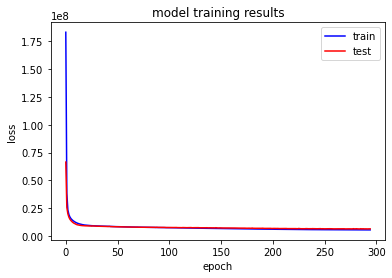

In [19]:
plot_metrics(history_base,"loss")

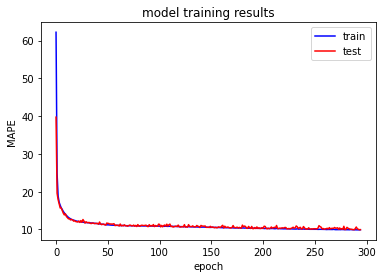

In [20]:
plot_metrics(history_base,"MAPE")

### Check price vs predicted value

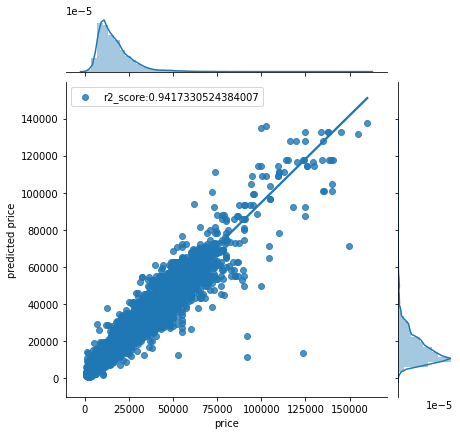

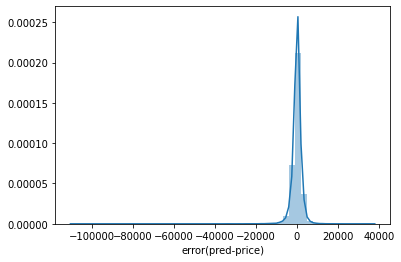

In [21]:
carPrice_NN.plot_pred_price()

### Pretty decent results and the error appear to be normal distribution

## Try a bigger model 

In [22]:
bigger_model = make_model([2056,2014,512,512],input_size,METRICS,1e-4,lr)

In [23]:
bigger_model.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2056)              425592    
_________________________________________________________________
dense_4 (Dense)              (None, 2014)              4142798   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1031680   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 5,863,239
Trainable params: 5,863,239
Non-trainable params: 0
_________________________________________________________________


In [24]:
carPrice_NN.base = bigger_model 

In [25]:
carPrice_NN.regression_metrics(X_train.values,y_train,X_test.values,y_test,
                              True,train,dev,MAX_EPOCH,V=0,callbacks=[EARLYSTOP])

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.944153,2326.280426,797.934717
test,0.934375,2581.197399,231.885005


In [26]:
bigger_model = carPrice_NN.regressor

In [27]:
bigger_model.save("bigger_model_nn.h5")

In [ ]:
# bigger_model = tfk.models.load_model("bigger_model_nn.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

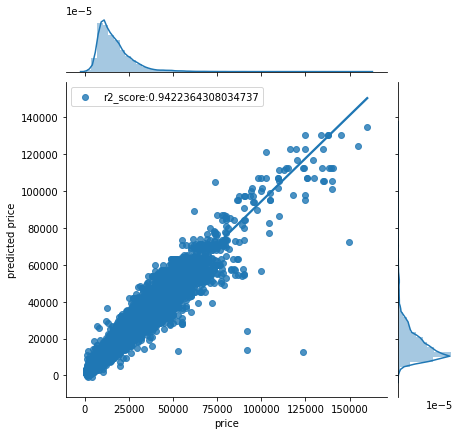

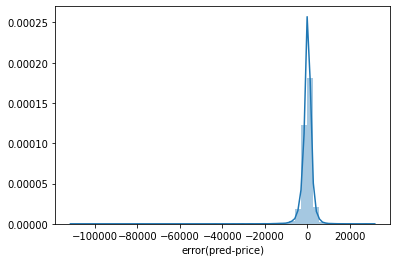

In [28]:
carPrice_NN.plot_pred_price()

### Pretty decent result and not over training the train data either

In [29]:
bigger_model_2 = make_model([2056,2014,512,512],input_size,METRICS,1e-4,5e-5)

In [30]:
bigger_model_2.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2056)              425592    
_________________________________________________________________
dense_9 (Dense)              (None, 2014)              4142798   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1031680   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 5,863,239
Trainable params: 5,863,239
Non-trainable params: 0
_________________________________________________________________


In [31]:
carPrice_NN.base = bigger_model_2

In [33]:
carPrice_NN.regression_metrics(X_train.values,y_train,X_test.values,y_test,
                              True,train,dev,MAX_EPOCH,V=0,callbacks=[EARLYSTOP])

Restoring model weights from the end of the best epoch.
Epoch 00167: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.947344,2258.842101,793.955687
test,0.936184,2545.376302,243.662601


In [34]:
bigger_model = carPrice_NN.regressor

In [35]:
bigger_model_2.save("bigger_model_2.h5")

In [ ]:
# bigger_model_2 = tfk.models.load_model("bigger_model_2.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

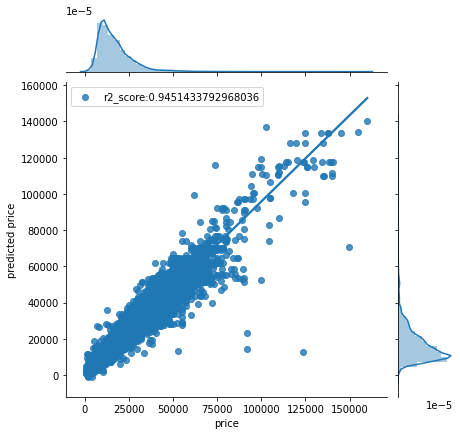

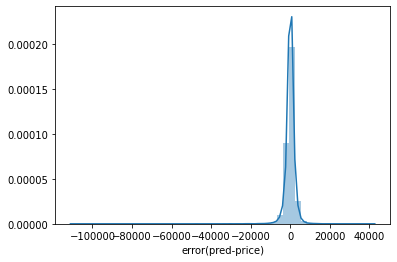

In [36]:
carPrice_NN.plot_pred_price()

### Since we have limited data, having bigger NN didn't seem to help with the improvement

------

### Looking at special cases of why the model has hard time predicting certain car price

In [37]:
price_table_final = carPrice_NN.price_diff()

In [38]:
price_table_final.head(20)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,...,model_EcoSport,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,price_diff_pct,price_diff_abs
11984,1,0,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,793.955687,793.955687
39711,1,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,691.749582,691.749582
39978,1,5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,642.527344,642.527344
71819,1,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,610.878109,610.878109
69135,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,427.644531,427.644531
44539,1,4,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,387.881550,387.881550
39540,1,5,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,348.738595,348.738595
71617,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,346.798310,346.798310
47201,1,5,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,343.698242,343.698242
77582,1,4,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,342.363363,342.363363


### Most of these models are older. The top cases have a weird combination of low car mileage but older year model 

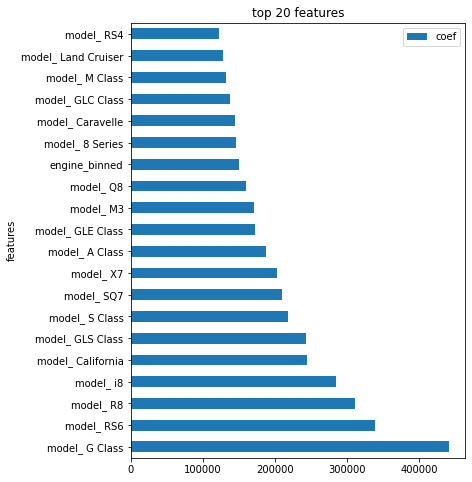

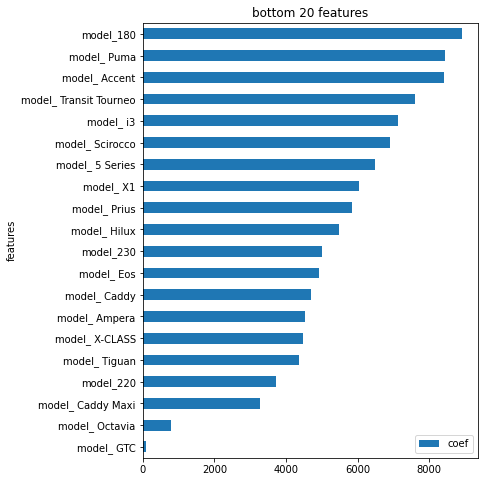

,features,score
75,model_ GTC,78.208405
115,model_ Octavia,790.220886
46,model_ Caddy Maxi,3264.645752
196,model_220,3712.030762
160,model_ Tiguan,4372.511719
...,...,...
48,model_ California,243807.437500
193,model_ i8,284316.812500
127,model_ R8,310598.562500
132,model_ RS6,338188.312500


In [39]:
model_coefs = coeff_estimation(bigger_model_2,5).flatten()
carPrice_NN.linear_feature_importance(NN_coefs=model_coefs)

### The NN models have mostly car model type as top and bottom features


____